In [2]:
import tensorflow as tf
import os
import time
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
# import pytorch
import random
import torch

2024-11-04 19:50:30.295768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 19:50:30.301103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 19:50:30.454764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-04 19:50:30.534403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 19:50:30.681109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
BUFFER_SIZE = 278
EPOCHS = 1
LAMBDA = 100
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
patch_size = 32
num_patches = (IMG_HEIGHT // patch_size) ** 2
projection_dim = 64
embed_dim = 64
num_heads = 4
ff_dim = 32
DATASET = 'liver'
assert IMG_WIDTH == IMG_HEIGHT, "image width and image height must have same dims"


In [4]:
# _URL = f'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/{DATASET}.tar.gz'

# path_to_zip = tf.keras.utils.get_file(f'{DATASET}.tar.gz',
#                                       origin=_URL,
#                                       extract=True)

# PATH = os.path.join(os.path.dirname(path_to_zip), f'{DATASET}_extracted/{DATASET}/')
# print(PATH)

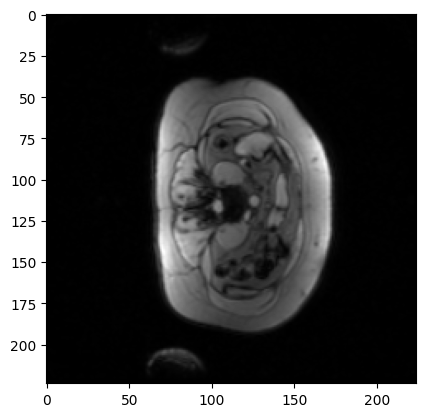

In [5]:
# this will return volume of dimension (H, W, D) = (224, 224, 24)
def load_nii_volume(file_path):
    """Load and return a 3D NII volume as a tensor, cast to float32."""
    nii_img = nib.load(file_path)
   # volume = torch.tensor(nii_img.get_fdata(), dtype=torch.float32)  # Convert to a float32 tensor
    volume = nii_img.get_fdata().astype(np.float32)
    return volume

# this will return a list and each item will have shape  [224, 224, 1]
def slice_nii_volume_to_2d(volume):
    """Slice a 3D NII volume into a list of 2D slices with debugging info."""
    slices = []
    for i in range(volume.shape[2]):  # Assuming shape is (H, W, D)
        slice_2d = volume[:, :, i]  # Extract 2D slice along the depth dimension
              
        # Skip slices that are empty or have very low variance
        if slice_2d.max() - slice_2d.min() < 1e-5:
            print(f"Skipping slice {i} due to low variance")
            continue
         # Add channel dimensions
        slice_2d_with_channel = np.expand_dims(slice_2d, axis=-1)
        slices.append(slice_2d_with_channel)
    return np.array(slices)
img = load_nii_volume('/home/dpach/Documents/RESEARCH/small_adult_anatomical_train/f_2428.nii')
slices_img = slice_nii_volume_to_2d(img)

re = load_nii_volume('/home/dpach/Documents/RESEARCH/small_adult_anatomical_train/f_2422.nii')
slices_re = slice_nii_volume_to_2d(re)
len(slices_img), len(slices_re)
plt.imshow(slices_img[1].squeeze(), cmap='gray')

In [6]:
# pass slice to 2d function

def resize_nii_slice(input_slice, real_slice, height, width):
    # Convert it into tensor
    # Resize the tensors
    resized_input = tf.image.resize(input_slice, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_real = tf.image.resize(real_slice, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_input, resized_real
resize_img, resize_real = resize_nii_slice(slices_img[0], slices_re[0], IMG_HEIGHT, IMG_WIDTH)


In [7]:
def normalize(input_tensor, real_tensor):
    input_tensor = (input_tensor / 127.5) - 1
    real_tensor = (real_tensor / 127.5) - 1
    return input_tensor, real_tensor

In [8]:
@tf.function
def random_jitter(input_slice, real_slice):
    input_image, real_image = resize_nii_slice(input_slice, real_slice, 256, 256)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_slice)
        real_image = tf.image.flip_left_right(real_slice)
    else:
        input_image = input_slice
        real_image = real_slice
    
    return input_image, real_image


(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


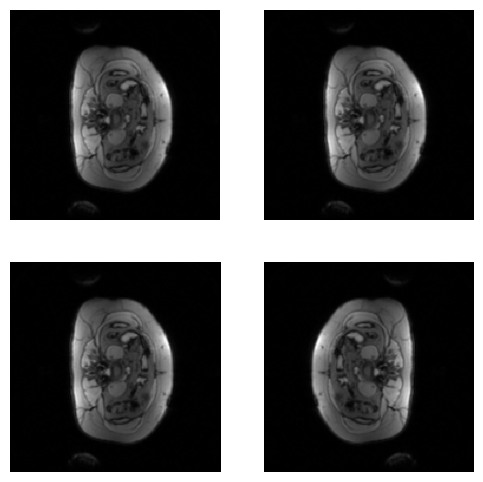

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(resize_img, resize_real)
    print(rj_inp.shape)
    rj_inp = np.squeeze(rj_inp.numpy())
    plt.subplot(2, 2, i+1)

    plt.imshow(rj_inp/255.0, cmap='gray')
    plt.axis('off')
plt.show()

In [10]:
path_train_adult= '/home/dpach/Documents/RESEARCH/Adult_Anatomical'
path_train_fat = '/home/dpach/Documents/RESEARCH/Adult_FatFrac'


In [11]:
def preprocess_single_slice_train(input_slice, real_slice):
    # Perform resizing, random jittering, and normalization
    resize_img, resize_real = resize_nii_slice(input_slice, real_slice, 256, 256)
    random_jitter_img, random_jitter_real = random_jitter(resize_img, resize_real)
    norm_img, norm_real = normalize(random_jitter_img, random_jitter_real)
    return norm_img, norm_real


def create_train_dataset_from_nii_SLICES(input_tensor, real_tensor):
    input_slice_list = slice_nii_volume_to_2d(input_tensor)
    real_slice_list = slice_nii_volume_to_2d(real_tensor)

    # Create TensorFlow datasets from the slice lists
    input_ds = tf.data.Dataset.from_tensor_slices(input_slice_list)
    real_ds = tf.data.Dataset.from_tensor_slices(real_slice_list)

    # Zip the two datasets together
    dataset = tf.data.Dataset.zip((input_ds, real_ds))

    # Map the preprocessing function onto the dataset
    dataset = dataset.map(lambda x, y: preprocess_single_slice_train(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset
@tf.function
def create_train_dataset_from_nii_files(file_paths):
    input_nii_file, real_nii_file = file_paths  # Unpack the tuple
    
    # Load the tensors (outside of @tf.function if these use I/O)
    input_tensor = load_nii_volume(input_nii_file)
    real_tensor = load_nii_volume(real_nii_file)
    
    # Create the dataset
    dataset = create_train_dataset_from_nii_SLICES(input_tensor, real_tensor)
    
    return dataset


In [12]:
def preprocess_single_slice_test(input_slice, real_slice):
    # Perform resizing and normalization
    resize_img, resize_real = resize_nii_slice(input_slice, real_slice, 256, 256)
    norm_img, norm_real = normalize(resize_img, resize_real)
    return norm_img, norm_real
def create_test_dataset_from_nii_SLICES(input_tensor, real_tensor):
    input_slice_list = slice_nii_volume_to_2d(input_tensor)
    real_slice_list = slice_nii_volume_to_2d(real_tensor)

    # Create TensorFlow datasets from the slice lists
    input_ds = tf.data.Dataset.from_tensor_slices(input_slice_list)
    real_ds = tf.data.Dataset.from_tensor_slices(real_slice_list)

    # Zip the two datasets together
    dataset = tf.data.Dataset.zip((input_ds, real_ds))

    # Map the preprocessing function onto the dataset
    dataset = dataset.map(lambda x, y: preprocess_single_slice_test(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

@tf.function
def create_test_dataset_from_nii_files(file_paths):
    input_nii_file, real_nii_file = file_paths  # Unpack the tuple
    
    # Load the tensors (outside of @tf.function if these use I/O)
    input_tensor = load_nii_volume(input_nii_file)
    real_tensor = load_nii_volume(real_nii_file)
    
    # Create the dataset
    dataset = create_test_dataset_from_nii_SLICES(input_tensor, real_tensor)
    
    return dataset



In [13]:
def get_file_pairs(input_dir, real_dir):
    # List all files in the input and real directories
    input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.nii')])
    real_files = sorted([os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.nii')])
    
    # Ensure the number of input and real files matches
    if len(input_files) != len(real_files):
        raise ValueError("The number of input and real files does not match.")
    
    # Create a list of (input_file, real_file) pairs
    file_pairs = list(zip(input_files, real_files))
    
    return file_pairs

def create_combined_dataset(input_dir, real_dir, split_ratio=0.8):
    file_pairs = get_file_pairs(input_dir, real_dir)  # Get all file pairs

    # Shuffle and split file pairs into training and testing sets
    random.shuffle(file_pairs)
    split_index = int(len(file_pairs) * split_ratio)
    train_pairs = file_pairs[:split_index]
    test_pairs = file_pairs[split_index:]

    # Create datasets for training and testing
    train_dataset = None
    test_dataset = None

    # Process training pairs
    for file_paths in train_pairs:
        # Preprocess with the function for training data
        dataset = create_train_dataset_from_nii_files(file_paths)

        # Combine datasets by concatenating them
        if train_dataset is None:
            train_dataset = dataset
        else:
            train_dataset = train_dataset.concatenate(dataset)

    # Process testing pairs
    for file_paths in test_pairs:
        # Preprocess with the function for testing data
        dataset = create_test_dataset_from_nii_files(file_paths)

        # Combine datasets by concatenating them
        if test_dataset is None:
            test_dataset = dataset
        else:
            test_dataset = test_dataset.concatenate(dataset)

    return train_dataset, test_dataset


In [14]:
import matplotlib.pyplot as plt

def display_dataset_samples(dataset, num_samples=2):
    # Take a few samples from the dataset and plot them
    for i, (input_slice, real_slice) in enumerate(dataset.take(num_samples)):
        # Convert tensors to numpy arrays for plotting
        input_slice = input_slice.numpy().squeeze()  # Squeeze to remove the channel dimension
        real_slice = real_slice.numpy().squeeze()
        
        # Create a figure to display input and corresponding real slices side by side
        plt.figure(figsize=(6, 3))
        
        # Display the input slice
        plt.subplot(1, 2, 1)
        plt.imshow(input_slice, cmap='gray')
        plt.title(f'Input Slice {i+1}')
        plt.axis('off')
        
        # Display the real slice
        plt.subplot(1, 2, 2)
        plt.imshow(real_slice, cmap='gray')
        plt.title(f'Real Slice {i+1}')
        plt.axis('off')
        
        plt.show()




In [15]:
# Count total slices to see if the count matches or not
def count_total_slices_in_directory(input_dir):
    total_slices = 0
    
    # List all NIfTI files in the directory
    nii_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.nii')]
    
    for nii_file in nii_files:
        # Load the NIfTI file
        nii_volume = nib.load(nii_file)
        nii_data = nii_volume.get_fdata()  # Get the data as a NumPy array
        
        # The number of slices is the size of the 3rd dimension
        num_slices = nii_data.shape[2]  # Assuming the 3rd dimension is the slice count
        total_slices += num_slices
    
    return total_slices


In [16]:
# Now time to read the whole directory and all the nii files and all the slices in that nii file and put those in a dataset

## Input Pipeline

In [17]:
tf.config.run_functions_eagerly(False)
train_dataset, test_dataset = create_combined_dataset(path_train_adult, path_train_fat, split_ratio=0.8)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [16]:
OUTPUT_CHANNELS = 1

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [19]:
def upsample(x, filters, kernel_size, strides=2):
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.LeakyReLU()(x)


In [20]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [21]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [22]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [23]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

# 64 64 1 generator

In [24]:

# def Generator():
#     inputs = tf.keras.layers.Input(shape=(64, 64, 1))
    
#     # Patch and Transformer block pipeline
#     patches = Patches(patch_size)(inputs)
#     encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
#     # Apply Transformer blocks
#     x = TransformerBlock(64, num_heads, ff_dim)(encoded_patches, training=True)
#     x = TransformerBlock(64, num_heads, ff_dim)(x, training=True)

#     # Reshape output to (8, 8, 64)
#     x = tf.keras.layers.Reshape((8, 8, 64))(x)
    
#     # Upsample to (16, 16, 256)
#     x = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
    
#     # Add residual block with 256 filters
#     x = residual_block(x, downsample=False, filters=256)
    
#     # Upsample to (32, 32, 128)
#     x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
    
#     # Add another residual block with 128 filters
#     x = residual_block(x, downsample=False, filters=128)
    
#     # Upsample to (64, 64, 64)
#     x = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
    
#     # Add residual block with 64 filters
#     x = residual_block(x, downsample=False, filters=64)
    
#     # Final Conv2DTranspose to reduce channels to 32, no further upsampling required
#     # Since the output is already (64, 64), you don't need any more strides larger than (1, 1)
#     x = tf.keras.layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
#     print(x.shape) 
#     # Return the generator model
#     return tf.keras.Model(inputs=inputs, outputs=x)

# Generator()


# 256 256 1 Generator

In [62]:

import tensorflow as tf

def Generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 1))
    
    # Patch and Transformer block pipeline
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Apply Transformer blocks
    x = TransformerBlock(projection_dim, num_heads, ff_dim)(encoded_patches, training=True)
    x = TransformerBlock(projection_dim, num_heads, ff_dim)(x, training=True)
    x = TransformerBlock(projection_dim, num_heads, ff_dim)(x, training=True)
    x = TransformerBlock(projection_dim, num_heads, ff_dim)(x, training=True)


    # Reshape output to (8, 8, 64)
    x = tf.keras.layers.Reshape((8, 8, 1024))(x)
    
    # Upsample to (16, 16, 512)
    x = tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Residual block with 512 filters
    x = residual_block(x, downsample=False, filters=512)
    
    # Upsample to (32, 32, 256)
    x = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Residual block with 256 filters
    x = residual_block(x, downsample=False, filters=256)
    
    # Upsample to (64, 64, 128)
    x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Residual block with 128 filters
    x = residual_block(x, downsample=False, filters=128)
    
    # Upsample to (128, 128, 64)
    x = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Residual block with 64 filters
    x = residual_block(x, downsample=False, filters=64)
    
    # Upsample to (256, 256, 32)
    x = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Residual block with 32 filters
    x = residual_block(x, downsample=False, filters=32)
    
    # Final Conv2D to get to (256, 256, 1)
    x = tf.keras.layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    print(x.shape) 
    # Return the generator model
    return tf.keras.Model(inputs=inputs, outputs=x)





In [46]:
# Create the generator model

generator = Generator()

(None, 256, 256, 1)


In [47]:
tf.config.run_functions_eagerly(False)

In [48]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [49]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# 256 256 1 discriminaotr

In [50]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input: Grayscale images of shape (256, 256, 1)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

    # Concatenate input and target: (bs, 256, 256, 2) because of grayscale (1 channel each)
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, 2)

    # Downsample layers
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    # Apply padding and Conv2D layers
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu )  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    # Create and return the model
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [51]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
discriminator.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 2)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      2,048 │ concatenate_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_2… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 33, 33,    │          0 │ leaky_re_lu_12[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,766,337 (10.55 MB)

 Trainable params: 2,764,545 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [52]:
tf.config.run_functions_eagerly(True)

In [53]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [56]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

def generate_batch_images(model, test_input, tar):
    for i in range(len(test_input)):
      prediction = model(test_input, training=True)
      plt.figure(figsize=(15, 15))

      display_list = [test_input[i], tar[i], prediction[i]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']
      
      for i in range(3):
          plt.subplot(1, 3, i+1)
          plt.title(title[i])
          # getting the pixel values between [0, 1] to plot it.
          plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
          plt.axis('off')
      plt.show()

In [57]:
generator.load_weights('/home/dpach/Documents/RESEARCH/vit-gan/notebooks/facades-gen.weights.h5')

ValueError: A total of 56 objects could not be loaded. Example error message for object <Dense name=dense_18, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(1024, 64), Received: value.shape=(64, 64). Target variable: <KerasVariable shape=(1024, 64), dtype=float32, path=patch_encoder_2/dense_18/kernel>

List of objects that could not be loaded:
[<Dense name=dense_18, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_23, built=True>, <Dense name=dense_24, built=True>, <LayerNormalization name=layer_normalization_20, built=True>, <LayerNormalization name=layer_normalization_21, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_25, built=True>, <Dense name=dense_26, built=True>, <LayerNormalization name=layer_normalization_22, built=True>, <LayerNormalization name=layer_normalization_23, built=True>, <Conv2DTranspose name=conv2d_transpose, built=True>, <BatchNormalization name=batch_normalization_3, built=True>, <Conv2D name=conv2d_5, built=True>, <BatchNormalization name=batch_normalization_4, built=True>, <Conv2D name=conv2d_6, built=True>, <BatchNormalization name=batch_normalization_5, built=True>, <Conv2DTranspose name=conv2d_transpose_1, built=True>, <BatchNormalization name=batch_normalization_6, built=True>, <Conv2D name=conv2d_7, built=True>, <BatchNormalization name=batch_normalization_7, built=True>, <Conv2D name=conv2d_8, built=True>, <BatchNormalization name=batch_normalization_8, built=True>, <Conv2DTranspose name=conv2d_transpose_2, built=True>, <BatchNormalization name=batch_normalization_9, built=True>, <Conv2D name=conv2d_9, built=True>, <BatchNormalization name=batch_normalization_10, built=True>, <Conv2D name=conv2d_10, built=True>, <BatchNormalization name=batch_normalization_11, built=True>, <Conv2DTranspose name=conv2d_transpose_3, built=True>, <BatchNormalization name=batch_normalization_12, built=True>, <Conv2D name=conv2d_11, built=True>, <BatchNormalization name=batch_normalization_13, built=True>, <Conv2D name=conv2d_12, built=True>, <BatchNormalization name=batch_normalization_14, built=True>, <Conv2DTranspose name=conv2d_transpose_4, built=True>, <BatchNormalization name=batch_normalization_15, built=True>, <Conv2D name=conv2d_13, built=True>, <BatchNormalization name=batch_normalization_16, built=True>, <Conv2D name=conv2d_14, built=True>, <BatchNormalization name=batch_normalization_17, built=True>, <Conv2D name=conv2d_15, built=True>]

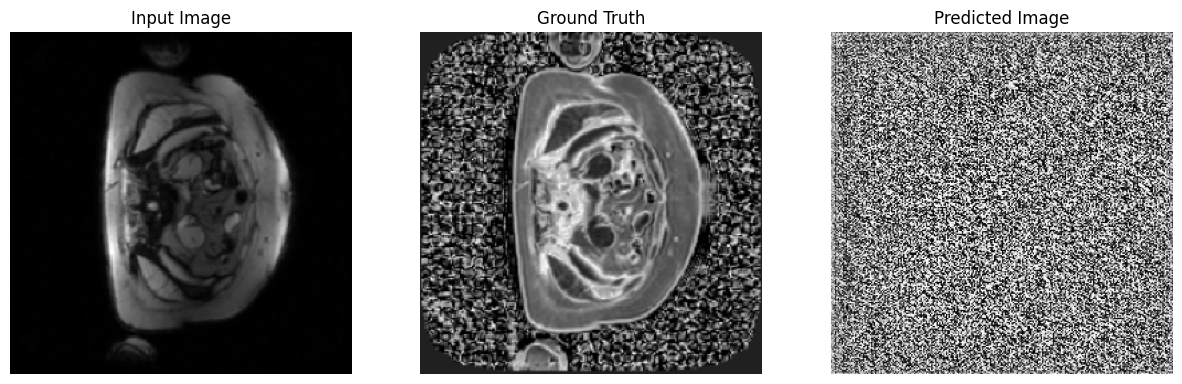

2024-11-01 17:48:17.005930: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [59]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Forward pass through generator and discriminator
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)

            # Calculate losses
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Compute gradients
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss


In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        # Clear previous output and display new images from test set
        #display.clear_output(wait=True)
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        print(f"Epoch: {epoch + 1}/{epochs}")

        # Training loop
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n + 1) % 100 == 0:  # Log progress every 100 steps
                print()
            
            # Perform the training step and return losses
            gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss = train_step(input_image, target, epoch)

        # Print epoch-wise loss summary every epoch
        print(f"\nEpoch {epoch + 1}:")
        print(f"Generator Total Loss: {gen_total_loss.numpy():.4f}, GAN Loss: {gen_gan_loss.numpy():.4f}, L1 Loss: {gen_l1_loss.numpy():.4f}")
        print(f"Discriminator Loss: {disc_loss.numpy():.4f}")

        generator.save_weights(f'{DATASET}-gen-epoch-{epoch + 1}.weights.h5')
        discriminator.save_weights(f'{DATASET}-disc-epoch-{epoch + 1}.weights.h5')
        print(f'Saved weights for epoch {epoch + 1}')       


        # Print time taken for the epoch
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

    # Save model weights after all epochs
    generator.save_weights(f'{DATASET}-gen.weights.h5')
    discriminator.save_weights(f'{DATASET}-disc.weights.h5')



def fit(train_ds, epochs, test_ds):
    # Lists to store the losses for plotting
    gen_total_losses = []
    disc_losses = []
    gen_gan_losses = []
    gen_l1_losses = []

    for epoch in range(epochs):
        start = time.time()

        # Clear previous output and display new images from test set
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        print(f"Epoch: {epoch + 1}/{epochs}")

        # Training loop
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n + 1) % 100 == 0:  # Log progress every 100 steps
                print()
            
            # Perform the training step and return losses
            gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss = train_step(input_image, target, epoch)

        # Append the losses for plotting
        gen_total_losses.append(gen_total_loss.numpy())
        disc_losses.append(disc_loss.numpy())
        gen_gan_losses.append(gen_gan_loss.numpy())
        gen_l1_losses.append(gen_l1_loss.numpy())

        # Print epoch-wise loss summary every epoch
        print(f"\nEpoch {epoch + 1}:")
        print(f"Generator Total Loss: {gen_total_loss.numpy():.4f}, GAN Loss: {gen_gan_loss.numpy():.4f}, L1 Loss: {gen_l1_loss.numpy():.4f}")
        print(f"Discriminator Loss: {disc_loss.numpy():.4f}")

        # Save weights every 100 epochs
        if (epoch + 1) % 100 == 0:
            generator.save_weights(f'{DATASET}-gen-epoch-{epoch + 1}.weights.h5')
            discriminator.save_weights(f'{DATASET}-disc-epoch-{epoch + 1}.weights.h5')
            print(f'Saved weights for epoch {epoch + 1}')       

        # Print time taken for the epoch
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

    # Save model weights after all epochs
    generator.save_weights(f'{DATASET}-gen.weights.h5')
    discriminator.save_weights(f'{DATASET}-disc.weights.h5')

    # Plot the losses
    plt.figure(figsize=(12, 8))

    plt.plot(range(1, epochs + 1), gen_total_losses, label="Generator Total Loss")
    plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss")
    plt.plot(range(1, epochs + 1), gen_gan_losses, label="Generator GAN Loss")
    plt.plot(range(1, epochs + 1), gen_l1_losses, label="Generator L1 Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Losses During Training")
    plt.legend()
    plt.grid()
    plt.show()


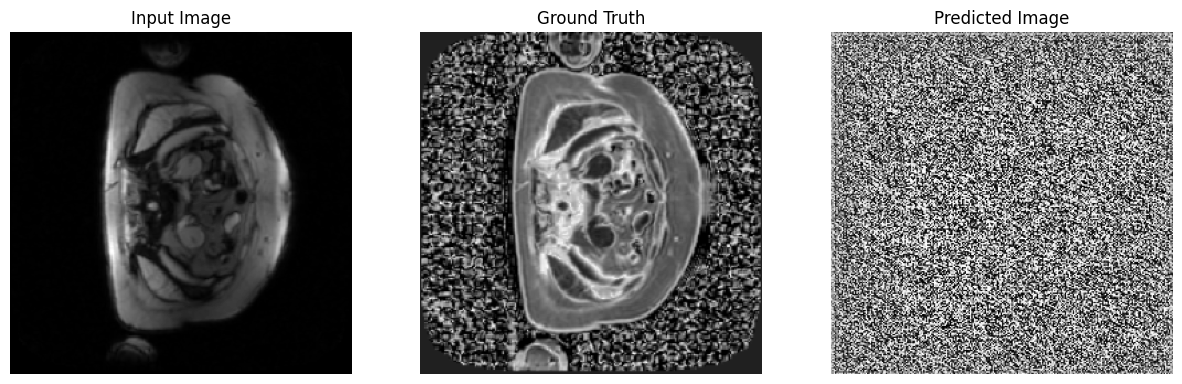

2024-11-01 17:48:18.620172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 1/10
.........................................................................
Epoch 1:
Generator Total Loss: 24.9503, GAN Loss: 3.4568, L1 Loss: 0.2149
Discriminator Loss: 0.0565
Saved weights for epoch 1
Time taken for epoch 1 is 4098.19 sec



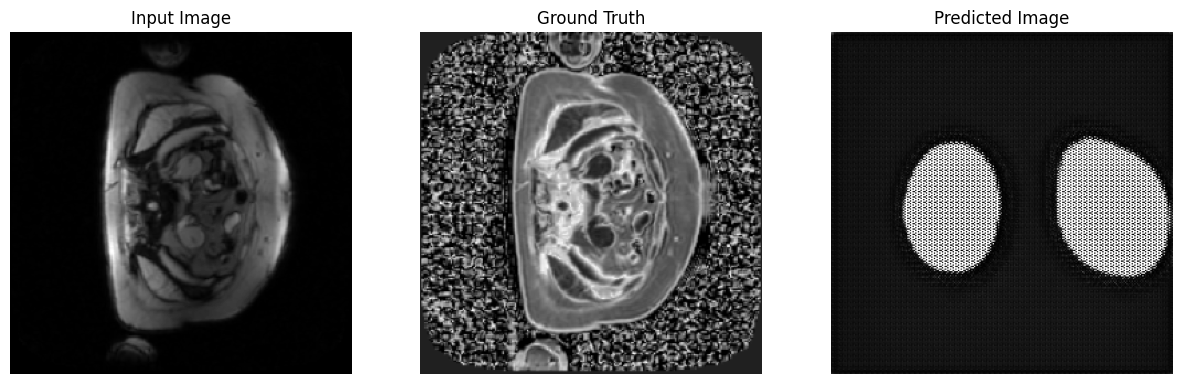

2024-11-01 18:56:36.594640: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 2/10
........................................................

KeyboardInterrupt: 

In [61]:
fit(train_dataset, 10, test_dataset) 

In [42]:
for inp, tar in test_dataset.take(1):
    outs = generator(inp)
    generate_batch_images(generator, inp, tar)

NameError: name 'generator' is not defined

In [ ]:
generator.load_weights(f'/home/dpach/Documents/RESEARCH/vit-gan/notebooks/facades-gen.weights.h5')
discriminator.load_weights(f'/home/dpach/Documents/RESEARCH/vit-gan/notebooks/facades-disc.weights.h5')
# load the h5 and give it a sample input and see if it produces the output or not
# if it does then we are good to go
# if not then we need to check the model again
# use the entire model instead  

In [ ]:
def display_image(images:list, display=True, save=False, name=None):
  import cv2
  import numpy as np
  from matplotlib import pyplot as plt

  img1, img2, img3, *_ = images
    
  img1 = np.array(img1[0]).astype(np.float32) * 0.5 + 0.5
  img2 = np.array(img2[0]).astype(np.float32) * 0.5 + 0.5
  img3 = np.array(img3[0]).astype(np.float32) * 0.5 + 0.5

  im_h = cv2.hconcat([img1, img2, img3])
  plt.xticks([])
  plt.yticks([])

  if display:
    plt.imshow(im_h)

  if save:
    if name is not None:
      plt.imsave(name, im_h.astype(np.float32))
    else:
      raise AttributeError('plt.imsave expected to have a name to save the image')

  return im_h


SyntaxError: incomplete input (3886253601.py, line 26)

In [ ]:
generator.load_weights(f'/home/dpach/Documents/RESEARCH/vit-gan/notebooks/facades-gen.weights.h5')

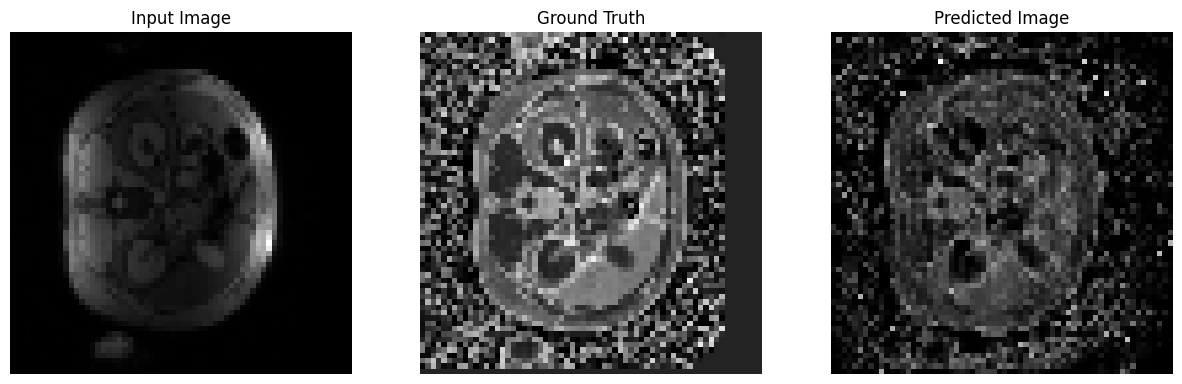

In [ ]:
for inp, tar in train_dataset.take(1):
    generate_images(generator, inp, tar)

array([[0.        , 0.00308123, 0.00308123, ..., 0.00030375, 0.00179198,
        0.00022638],
       [0.00308123, 0.00084034, 0.00458184, ..., 0.01065573, 0.05517322,
        0.00531504],
       [0.00242096, 0.00410163, 0.0032613 , ..., 0.00376296, 0.01176721,
        0.01522231],
       ...,
       [0.00308123, 0.00066027, 0.00084034, ..., 0.        , 0.        ,
        0.        ],
       [0.00242096, 0.0037415 , 0.00084034, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

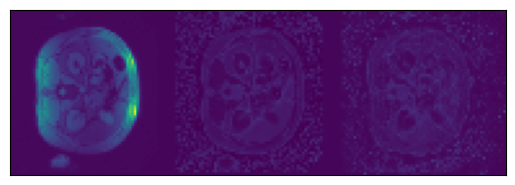

In [ ]:
display_image([inp, tar, generator(inp)], save=True, name='f4.png')